<a href="https://colab.research.google.com/github/a14984197/Involutional-neural-networks/blob/main/Involutional_neural_networks%EF%BC%88%E5%85%A7%E6%8D%B2%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 介紹
卷積是大多數現代電腦視覺神經網路的基礎。卷積核與空間無關且特定於通道。因此，它無法適應不同空間位置的不同視覺模式。除了與位置相關的問題之外，卷積的感受野也為捕捉遠端空間互動帶來了挑戰。

為了解決上述問題，Li 等人。等人。重新思考Involution: Inverting the Inherence of Convolution for VisualRecognition 中的捲積屬性 。作者提出了“對合內核”，即位置特定且通道不可知的。由於操作的位置特定性，作者表示自註意力屬於內捲設計範式。

這個例子描述了卷積核，比較了兩種影像分類模型，一種使用卷積，另一種使用卷積，也嘗試與自註意力層進行比較。

### 設定

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# Set seed for reproducibility.
tf.random.set_seed(42)

### 卷積
卷積仍然是電腦視覺深度神經網路的支柱。要理解Involution，就需要先講卷積運算。

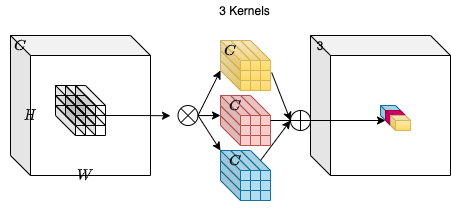

考慮維度為H、W和 C_in的輸入張量X。我們採用C_out卷積核的集合，每個卷積核的形狀為K、K、C_in。透過輸入張量和內核之間的乘加運算，我們得到維度為H、W、C_out的輸出張量Y。

在上圖中C_out=3。這使得輸出張量的形狀為 H、W 和 3。可以注意到，卷積核不依賴輸入張量的空間位置，這使得它與 位置無關。另一方面，輸出張量中的每個通道都基於特定的捲積濾波器，這使得 通道特定。

### 內捲化
這個想法是擁有一個既特定於位置 又與通道無關的操作。嘗試實現這些特定屬性提出了挑戰。使用固定數量的對合核（對於每個空間位置），我們將無法處理可變解析度輸入張量。

為了解決這個問題，作者考慮了產生以特定空間位置為條件的每個內核。透過這種方法，我們應該能夠輕鬆處理可變解析度輸入張量。下圖提供了對此內核生成方法的直觀了解。

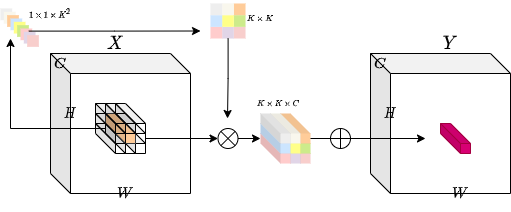


In [2]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

### 測試Involution層

In [3]:
# Define the input tensor.
input_tensor = tf.random.normal((32, 256, 256, 3))

# Compute involution with stride 1.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, name="inv_1"
)(input_tensor)
print(f"with stride 1 ouput shape: {output_tensor.shape}")

# Compute involution with stride 2.
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=2, reduction_ratio=1, name="inv_2"
)(input_tensor)
print(f"with stride 2 ouput shape: {output_tensor.shape}")

# Compute involution with stride 1, channel 16 and reduction ratio 2.
output_tensor, _ = Involution(
    channel=16, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3"
)(input_tensor)
print(
    "with channel 16 and reduction ratio 2 ouput shape: {}".format(output_tensor.shape)
)

with stride 1 ouput shape: (32, 256, 256, 3)
with stride 2 ouput shape: (32, 128, 128, 3)
with channel 16 and reduction ratio 2 ouput shape: (32, 256, 256, 3)


### 影像分類
在本節中，我們將建立一個影像分類器模型。將有兩種模型，一種帶有捲積，另一種帶有捲積。

圖像分類模型很大程度上受到 Google 的捲積神經網路 (CNN) 教程的啟發。

### 取得 CIFAR10 資料集

In [4]:
# Load the CIFAR10 dataset.
print("loading the CIFAR10 dataset...")
(
    (train_images, train_labels),
    (
        test_images,
        test_labels,
    ),
) = keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1.
(train_images, test_images) = (train_images / 255.0, test_images / 255.0)

# Shuffle and batch the dataset.
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    .shuffle(256)
    .batch(256)
)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(256)

loading the CIFAR10 dataset...
170498071/170498071 [==============================] - 2s 0us/step


### 視覺化數據

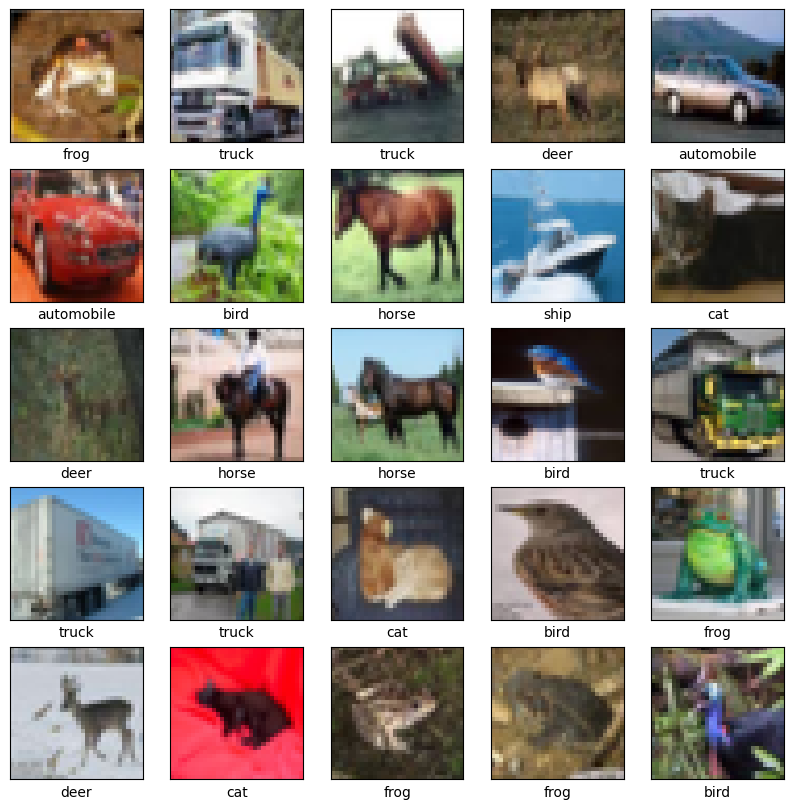

In [5]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### 卷積神經網絡

In [6]:
# Build the conv model.
print("building the convolution model...")
conv_model = keras.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding="same"),
        keras.layers.ReLU(name="relu1"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), padding="same"),
        keras.layers.ReLU(name="relu2"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), padding="same"),
        keras.layers.ReLU(name="relu3"),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(10),
    ]
)

# Compile the mode with the necessary loss function and optimizer.
print("compiling the convolution model...")
conv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Train the model.
print("conv model training...")
conv_hist = conv_model.fit(train_ds, epochs=20, validation_data=test_ds)

building the convolution model...
compiling the convolution model...
conv model training...
Epoch 1/20
196/196 [==============================] - 117s 573ms/step - loss: 1.6758 - accuracy: 0.3974 - val_loss: 1.3680 - val_accuracy: 0.5088
Epoch 2/20
196/196 [==============================] - 102s 523ms/step - loss: 1.2705 - accuracy: 0.5530 - val_loss: 1.1660 - val_accuracy: 0.5891
Epoch 3/20
196/196 [==============================] - 104s 529ms/step - loss: 1.0897 - accuracy: 0.6184 - val_loss: 1.0902 - val_accuracy: 0.6127
Epoch 4/20
196/196 [==============================] - 100s 512ms/step - loss: 0.9750 - accuracy: 0.6590 - val_loss: 0.9806 - val_accuracy: 0.6622
Epoch 5/20
196/196 [==============================] - 104s 533ms/step - loss: 0.9003 - accuracy: 0.6867 - val_loss: 0.9743 - val_accuracy: 0.6644
Epoch 6/20
196/196 [==============================] - 100s 510ms/step - loss: 0.8298 - accuracy: 0.7097 - val_loss: 0.9353 - val_accuracy: 0.6767
Epoch 7/20
196/196 [============

### 內捲神經網絡

In [7]:
# Build the involution model.
print("building the involution model...")

inputs = keras.Input(shape=(32, 32, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(10)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(train_ds, epochs=20, validation_data=test_ds)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/20
196/196 [==============================] - 97s 455ms/step - loss: 2.2822 - accuracy: 0.1647 - val_loss: 2.2723 - val_accuracy: 0.1363
Epoch 2/20
196/196 [==============================] - 99s 506ms/step - loss: 2.0191 - accuracy: 0.2924 - val_loss: 1.9549 - val_accuracy: 0.2971
Epoch 3/20
196/196 [==============================] - 89s 454ms/step - loss: 1.8540 - accuracy: 0.3410 - val_loss: 1.7952 - val_accuracy: 0.3578
Epoch 4/20
196/196 [==============================] - 99s 504ms/step - loss: 1.7774 - accuracy: 0.3709 - val_loss: 1.7481 - val_accuracy: 0.3820
Epoch 5/20
196/196 [==============================] - 90s 459ms/step - loss: 1.7345 - accuracy: 0.3870 - val_loss: 1.7111 - val_accuracy: 0.4008
Epoch 6/20
196/196 [==============================] - 89s 455ms/step - loss: 1.6994 - accuracy: 0.4020 - val_loss: 1.6664 - val_accuracy: 0.4176
Epoch 7/20
196/196 [=====================

### 比較
在本節中，我們將研究這兩個模型並比較一些要點。

參數
可以看到，採用類似的架構，CNN 中的參數比 INN（內捲神經網路）的參數大得多。

In [8]:
conv_model.summary()

inv_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 relu1 (ReLU)                (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 relu2 (ReLU)                (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                 

### 損失和準確度圖
此處，損失圖和準確度圖顯示 INN 學習速度較慢（參數較低）。

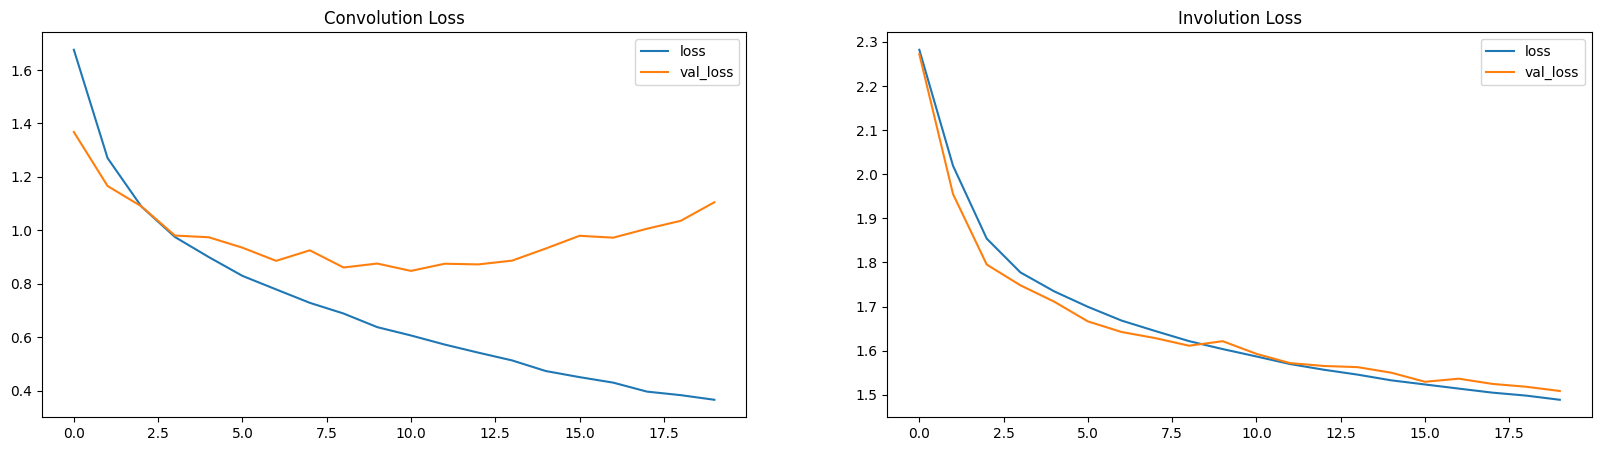

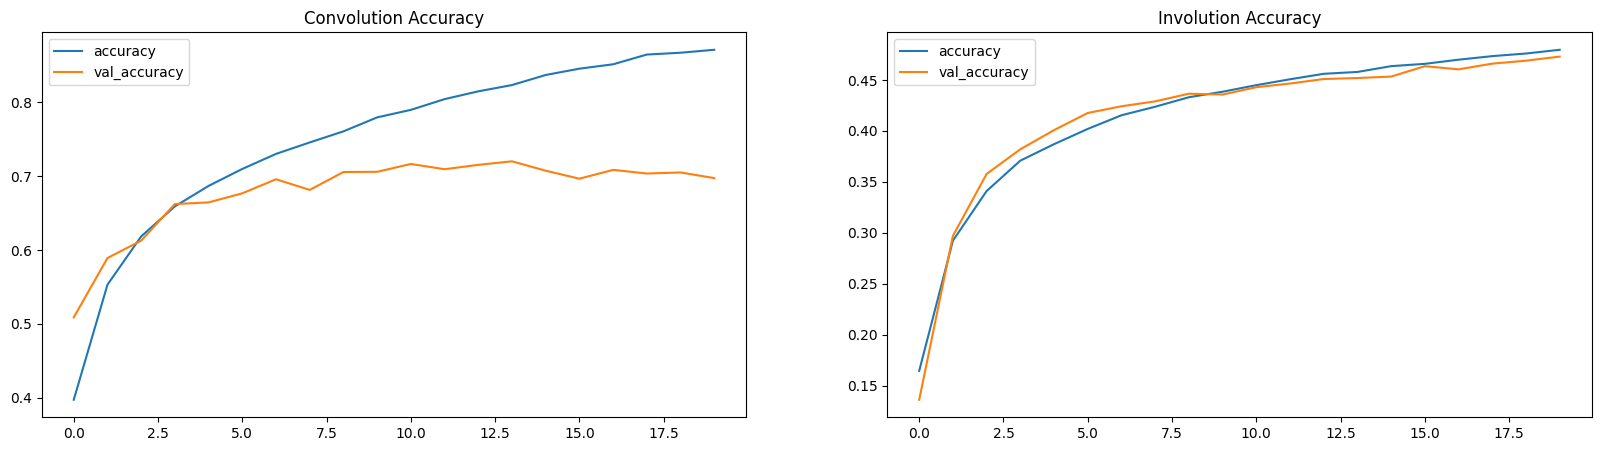

In [9]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Loss")
plt.plot(conv_hist.history["loss"], label="loss")
plt.plot(conv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Convolution Accuracy")
plt.plot(conv_hist.history["accuracy"], label="accuracy")
plt.plot(conv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

plt.show()

### 可視化卷積核
為了可視化內核，我們從每個對合內取得K×K值的總和。不同空間位置的所有代表都構成了對應的熱圖。

作者提到：

“我們提出的內卷讓人想起自我關注，本質上可能成為它的廣義版本。”

透過內核的可視化，我們確實可以獲得影像的注意力圖。學習到的對合核關注輸入張量的各個空間位置。位置 特定的屬性使得合成為自註意力所屬的模型的通用空間。

1/1 [==============================] - 0s 23ms/step


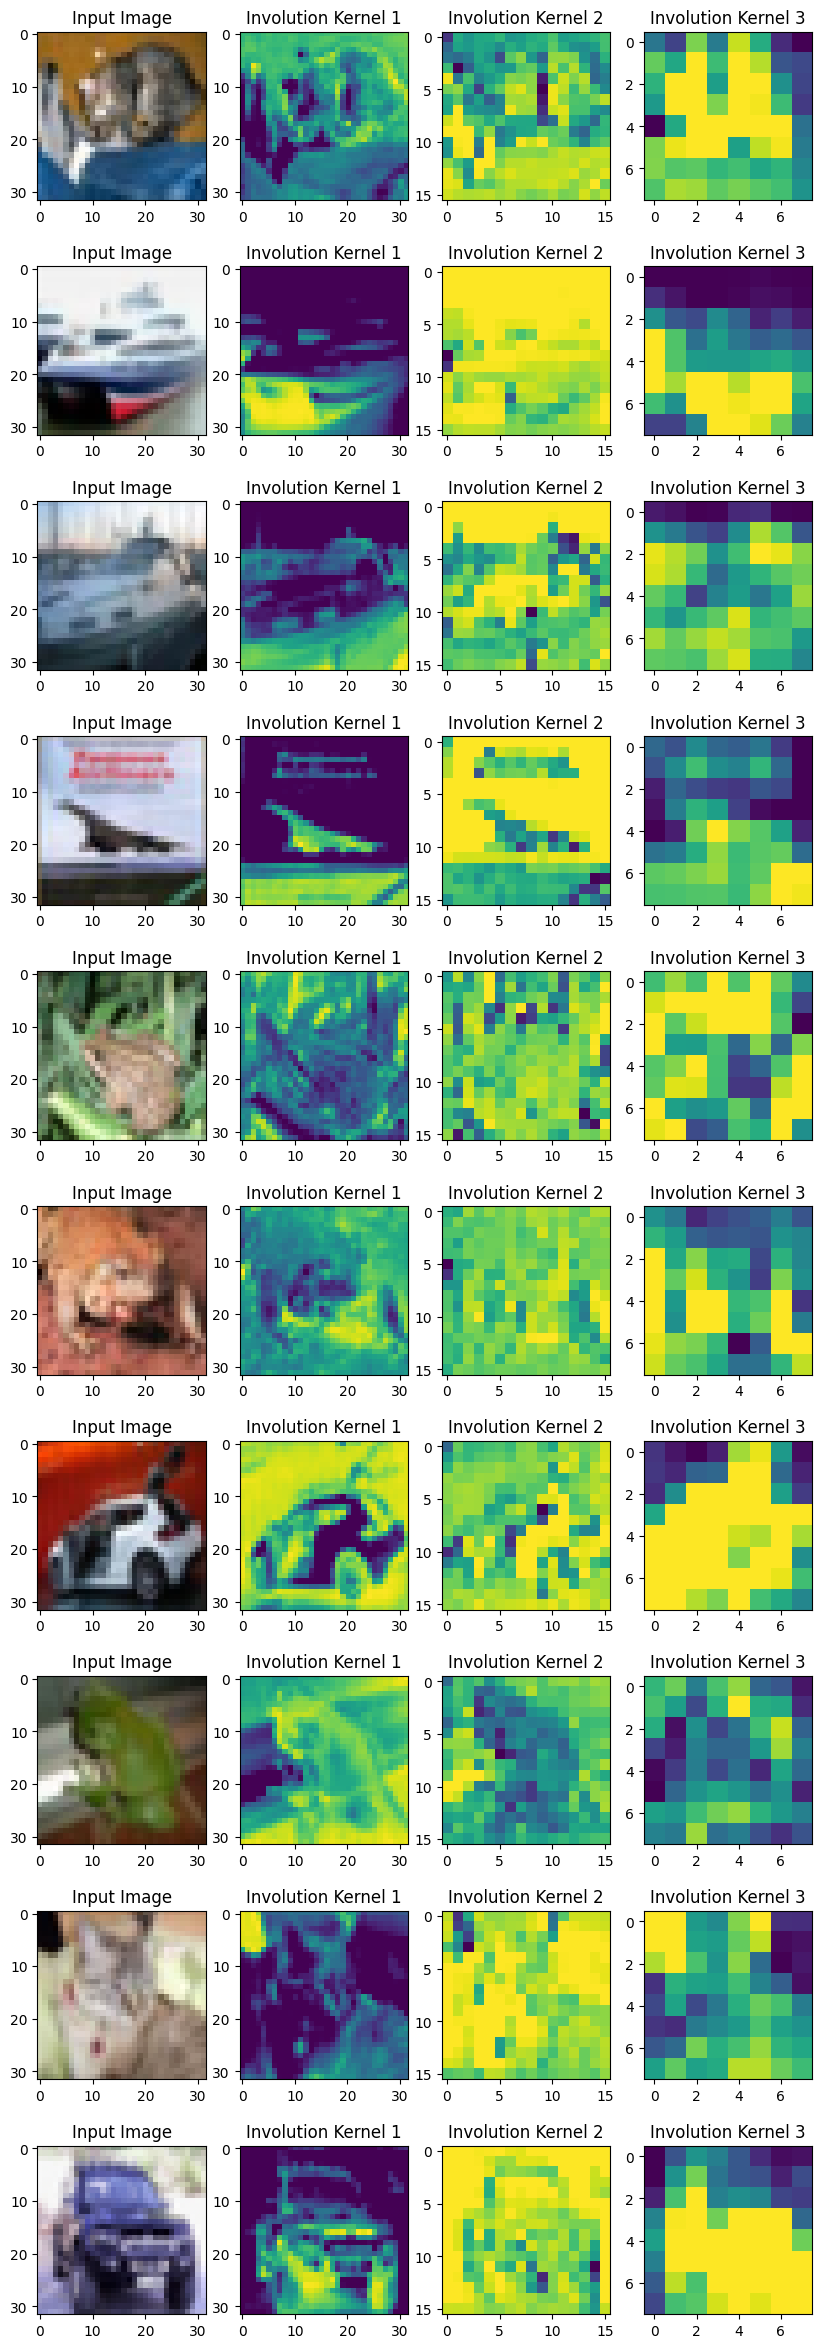

In [10]:
layer_names = ["inv_1", "inv_2", "inv_3"]
outputs = [inv_model.get_layer(name).output[1] for name in layer_names]
vis_model = keras.Model(inv_model.input, outputs)

fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 30))

for ax, test_image in zip(axes, test_images[:10]):
    (inv1_kernel, inv2_kernel, inv3_kernel) = vis_model.predict(test_image[None, ...])
    inv1_kernel = tf.reduce_sum(inv1_kernel, axis=[-1, -2, -3])
    inv2_kernel = tf.reduce_sum(inv2_kernel, axis=[-1, -2, -3])
    inv3_kernel = tf.reduce_sum(inv3_kernel, axis=[-1, -2, -3])

    ax[0].imshow(keras.utils.array_to_img(test_image))
    ax[0].set_title("Input Image")

    ax[1].imshow(keras.utils.array_to_img(inv1_kernel[0, ..., None]))
    ax[1].set_title("Involution Kernel 1")

    ax[2].imshow(keras.utils.array_to_img(inv2_kernel[0, ..., None]))
    ax[2].set_title("Involution Kernel 2")

    ax[3].imshow(keras.utils.array_to_img(inv3_kernel[0, ..., None]))
    ax[3].set_title("Involution Kernel 3")

### 結論
在此範例中，主要重點是建立一個Involution可以輕鬆重複使用的層。雖然我們的比較是基於特定任務，但您可以隨意將該圖層用於不同的任務並報告您的結果。

在我看來，內捲的關鍵在於它與自註意力的關係。特定於位置和特定於通道的處理背後的直覺在許多任務中都是有意義的。